**Torchlens** is a Python package for easily extracting and understanding the results of every single operation performed inside a PyTorch neural network model.  Its core functionality includes:
1. extracting the activations from any intermediate computation inside a PyTorch neural network model,
2. fully characterizing where those activations come from, via providing a complete log of every operation that happens during a model's forward pass, and
3. visualizing the complete computation graph of a model's forward pass.

This notebook demonstrates how to use torchlens.

In [35]:
import torch
from torch import nn
import torchvision
import torchlens as tl

The core function in torchlens is get_model_activations. Simply give it the model and input, and it'll take care of everything else, and return an object containing a log of everything that happened during the model's forward pass: not just the activations, but lots of information about the model's full computation graph. By setting vis_opt to 'unrolled' or 'rolled', it will also visualize the computation graph for us.

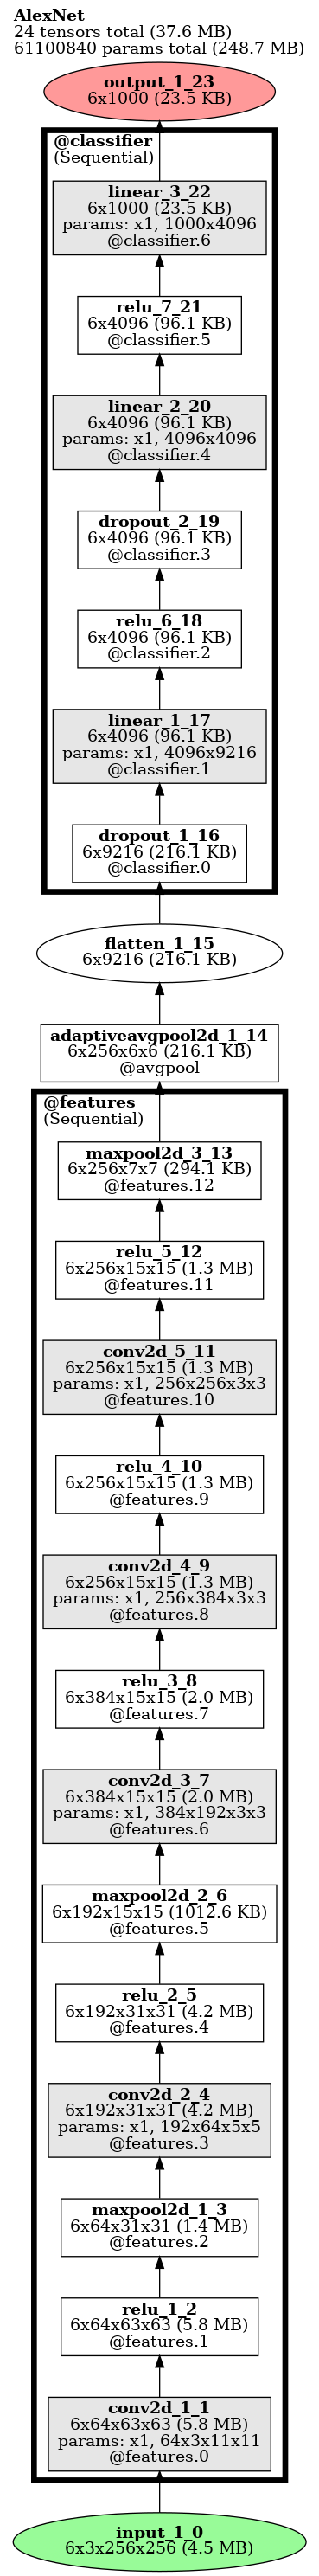

Log of AlexNet forward pass (0.409s elapsed):
	Model structure: purely feedforward, without branching; 23 total modules.
	24 tensors (37.6 MB) computed in forward pass; 24 tensors (37.6 MB) saved.
	16 parameter operations (61100840 params total; 248.7 MB).
	Random seed: 1256577664
	Module Hierarchy (based on computation order, not on the model object structure):
		features:
		    features.0, features.1, features.2, features.3, features.4, features.5, features.6, features.7, 
		    features.8, features.9, features.10, features.11, features.12
		avgpool
		classifier:
		    classifier.0, classifier.1, classifier.2, classifier.3, classifier.4, classifier.5, classifier.6
	Layers:
		0: input_1_0 
		1: conv2d_1_1 
		2: relu_1_2 
		3: maxpool2d_1_3 
		4: conv2d_2_4 
		5: relu_2_5 
		6: maxpool2d_2_6 
		7: conv2d_3_7 
		8: relu_3_8 
		9: conv2d_4_9 
		10: relu_4_10 
		11: conv2d_5_11 
		12: relu_5_12 
		13: maxpool2d_3_13 
		14: adaptiveavgpool2d_1_14 
		15: flatten_1_15 
		16: dropout_1_16 
		

In [21]:
alexnet = torchvision.models.alexnet(pretrained=True)
x = torch.rand(6, 3, 256, 256)
model_history = tl.get_model_activations(alexnet, x, vis_opt='unrolled')
model_history

From the model_history object, we can pull out the results of any operation that happened in the model's forward pass just by indexing this object. By default, operations are named with the convention that (for instance)  "conv2d_4_9" means the 4th convolution operation, and the 9th operation overall:

In [22]:
model_history['conv2d_4_9']

Layer conv2d_4_9, operation 10/24 (5.436E-03s elapsed):
	Output tensor: shape=(6, 256, 15, 15), dype=torch.float32, size=1.3 MB
		tensor([[ 0.2474,  0.4836, -0.5388,  1.2898,  0.7570],
        [-0.2907, -0.5752, -2.3351, -1.9399, -1.9073],
        [-0.3338, -1.7095, -3.2312, -3.0273, -2.2316],
        [ 0.3486, -2.7448, -4.1225, -4.1479, -3.6078],
        [ 0.5817, -2.4029, -4.3287, -4.0505, -4.2940]])...
	Params: Computed from params with shape (256,), (256, 384, 3, 3); 884992 params total (3.4 MB)
	Parent Layers: relu_3_8
	Child Layers: relu_4_10
	Function: conv2d (gradfunc=ThnnConv2DBackward) 
	Computed inside module: features.8
	Output of modules: features.8
	Output of bottom-level module: features.8
	Lookup keys: -15, 9, conv2d_4_9, conv2d_4_9:1, features.8, features.8:1

To pull out the actual activations, just get the tensor_contents field:


In [4]:
model_history['conv2d_4_9'].tensor_contents

tensor([[[[ -0.2184,   1.2648,   0.3245,  ...,   0.8762,   2.9733,   3.0142],
          [ -0.4855,  -0.7066,  -2.1302,  ...,  -3.0155,   0.9246,   1.6268],
          [ -0.2834,  -1.4175,  -2.8993,  ...,  -4.9052,  -0.6647,   1.4520],
          ...,
          [ -1.5783,  -3.0859,  -4.6237,  ...,  -5.2058,  -0.6862,   0.0797],
          [ -2.1161,  -2.6871,  -3.0536,  ...,  -3.2742,  -0.5718,  -0.4847],
          [  1.9322,   2.6934,   2.7331,  ...,   3.4988,   5.1803,   4.4050]],

         [[ -5.0321,  -4.7673,  -4.1095,  ...,  -5.6450,  -7.0342,  -6.8027],
          [ -5.5169,  -7.3781,  -6.1342,  ...,  -6.0653,  -8.8645,  -8.2232],
          [ -4.3805,  -6.6583,  -5.3800,  ...,  -5.7458,  -7.4263,  -6.6276],
          ...,
          [ -5.2653,  -7.9954,  -5.9186,  ...,  -5.1302,  -7.8912,  -7.8232],
          [ -6.2467,  -8.7441,  -7.8649,  ...,  -6.5444,  -9.2167,  -8.5065],
          [ -3.6657,  -3.9818,  -4.9171,  ...,  -4.0205,  -5.3587,  -5.4112]],

         [[ -1.5237,  -4.0150,

Torchlens also allows you to pull out the results of operations based on their ordinal position in the network, just like indexing a list:

In [12]:
print("*****These are the activations from the first layer*****")
print(model_history[1])
print("\n\n*****These are the activations from the fifth layer*****")
print(model_history[5])
print("\n\n*****These are the activations from the fourth-to-last layer*****")
print(model_history[-4])

*****These are the activations from the first layer*****
Layer conv2d_1_1, operation 2/24 (1.409E-02s elapsed):
	Output tensor: shape=(6, 64, 63, 63), dype=torch.float32, size=5.8 MB
		tensor([[-1.3171, -1.5632, -0.6218, -2.0415, -1.9403],
        [-0.8804, -1.1241, -0.8226, -0.9142, -1.7564],
        [-1.2713, -0.8470, -0.6996, -1.2530, -1.2120],
        [-0.7812, -1.0202, -1.1162, -0.5757, -2.0190],
        [ 0.0229,  0.5894, -1.9249, -1.9624, -0.2850]])...
	Params: Computed from params with shape (64,), (64, 3, 11, 11); 23296 params total (91.1 KB)
	Parent Layers: input_1_0
	Child Layers: relu_1_2
	Function: conv2d (gradfunc=ThnnConv2DBackward) 
	Computed inside module: features.0
	Output of modules: features.0
	Output of bottom-level module: features.0
	Lookup keys: -23, 1, conv2d_1_1, conv2d_1_1:1, features.0, features.0:1


*****These are the activations from the fifth layer*****
Layer relu_2_5, operation 6/24 (8.571E-04s elapsed):
	Output tensor: shape=(6, 192, 31, 31), dype=tor

Finally, you can also pull out activations based on any modules that they're the output of (at any level of module nesting):


In [16]:
print("*****These are the activations from the 'features' module of AlexNet (prior to the fully connected layers)*****")
print(model_history['features'])
print("\n\n*****These are the activations from the third submodule in the 'classifier' module of AlexNet*****")
print(model_history['classifier.2'])

*****These are the activations from the 'features' module of AlexNet (prior to the fully connected layers)*****
Layer maxpool2d_3_13, operation 14/24 (2.835E-04s elapsed):
	Output tensor: shape=(6, 256, 7, 7), dype=torch.float32, size=294.1 KB
		tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])...
	Params: no params used
	Parent Layers: relu_5_12
	Child Layers: adaptiveavgpool2d_1_14
	Function: max_pool2d (gradfunc=MaxPool2DWithIndicesBackward) 
	Computed inside module: features.12
	Output of modules: features.12, features
	Output of bottom-level module: features.12
	Lookup keys: -11, 13, features, features.12, features.12:1, features:1, maxpool2d_3_13, maxpool2d_3_13:1


*****These are the activations from the third submodule in the 'decoder' module of AlexNet*****
Layer relu_6_18, operation 19/24 (3.664E-04s elapsed):
	Output tensor: shape=(6, 4096), dype=torch.float32, size=96.1 KB
	

And you can iterate through the different layers like a list:


In [25]:
print(len(model_history))
for layer in model_history:
    print(layer)

24
Layer input_1_0, operation 1/24 (0.000E+00s elapsed):
	Output tensor: shape=(6, 3, 256, 256), dype=torch.float32, size=4.5 MB
		tensor([[0.4092, 0.2729, 0.2624, 0.0721, 0.9220],
        [0.1495, 0.9890, 0.1779, 0.2873, 0.4940],
        [0.0528, 0.9125, 0.2171, 0.6139, 0.2011],
        [0.2039, 0.4166, 0.6274, 0.1719, 0.9227],
        [0.3149, 0.3083, 0.9387, 0.7699, 0.1852]])...
	Params: no params used
	Parent Layers: no parent layers
	Child Layers: conv2d_1_1
	Output of modules: none
	Lookup keys: -24, 0, input_1_0, input_1_0:1
Layer conv2d_1_1, operation 2/24 (2.054E-02s elapsed):
	Output tensor: shape=(6, 64, 63, 63), dype=torch.float32, size=5.8 MB
		tensor([[-1.0461, -1.9718, -1.8659, -0.7349, -1.2874],
        [-1.3351, -1.9811, -1.1084, -0.3582, -0.6073],
        [-1.2952, -0.6508, -0.3046, -1.0721, -0.8328],
        [ 0.1546,  0.5168, -0.7352, -1.0767, -1.5553],
        [-0.2535, -2.4304, -1.2862, -1.2886, -1.0402]])...
	Params: Computed from params with shape (64,), (64, 3,

By default, torchlens saves the results of all the intermediate operations in a model. This will always only take just one line of code. However, for big models this might eat up a lot of memory, and maybe you want to take a look at what's going on in the model first so you can choose which layers you want. In this case, two other functions will come in handy (note that these provide just a subset of the functionality of get_model_activations):

1. show_model_graph, which will visualize the model's forward pass without saving any activations.
2. get_model_structure, which will pull out all the same graph metadata (in the same format) as get_model_activations without saving the tensors themselves, and


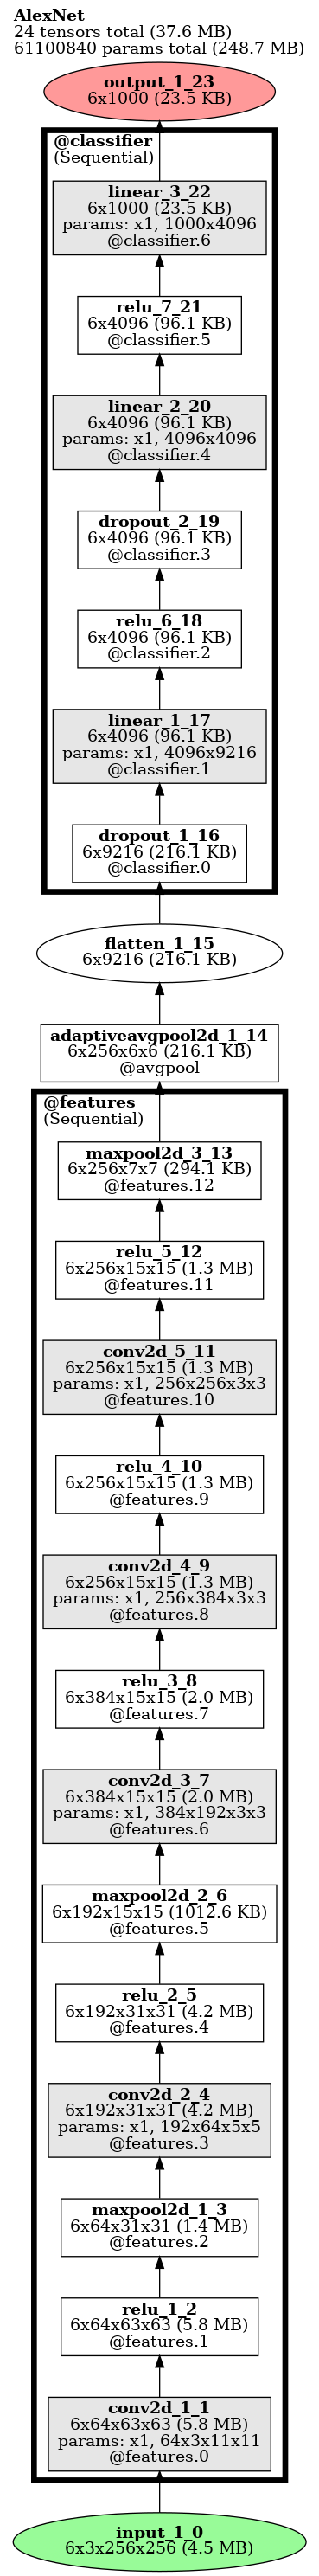

In [27]:
tl.show_model_graph(alexnet, x)

The graph visual shows you everything that happens in the model's forward pass:
- Each node of the graph is a tensor, with input tensors in green, output tensors in red, and tensors from operations associated with parameters in grey (e.g., convolutions are grey since they have saved weights, whereas relus are not, since they have no saved parameters).
- Nodes are rectangular if they correspond to outputs of a module, and ovals if they are outputs of operations that are not a module (e.g., flatten_1_15).
- The text in each node tells you the layer name (e.g., conv2d_1_1), the shape and file size of the output tensor, the shape of any params if applicable, and the "module address" of the layer (e.g., 'features.1' refers to the module features.1 of AlexNet)
- Box outlines show higher-level modules (e.g., AlexNet's 'features' module) that contain multiple operations.
- Finally, the visual also indicates the total number of tensors saved and their collective file size, along with the number of model parameters and associated file size.

Let's look at the structure of the model using get_model_structure; remember that this gives the exact same metadata as get_model_activations, but doesn't save any activations. Simply printing the object will give us some information about what happens during the forward pass:

In [29]:
model_structure = tl.get_model_structure(alexnet, x)
model_structure

Log of AlexNet forward pass (0.294s elapsed):
	Model structure: purely feedforward, without branching; 23 total modules.
	24 tensors (37.6 MB) computed in forward pass; 0 tensors (0 B) saved.
	16 parameter operations (61100840 params total; 248.7 MB).
	Random seed: 3565071100
	Module Hierarchy (based on computation order, not on the model object structure):
		features:
		    features.0, features.1, features.2, features.3, features.4, features.5, features.6, features.7, 
		    features.8, features.9, features.10, features.11, features.12
		avgpool
		classifier:
		    classifier.0, classifier.1, classifier.2, classifier.3, classifier.4, classifier.5, classifier.6
	Layers:
		0: input_1_0 
		1: conv2d_1_1 
		2: relu_1_2 
		3: maxpool2d_1_3 
		4: conv2d_2_4 
		5: relu_2_5 
		6: maxpool2d_2_6 
		7: conv2d_3_7 
		8: relu_3_8 
		9: conv2d_4_9 
		10: relu_4_10 
		11: conv2d_5_11 
		12: relu_5_12 
		13: maxpool2d_3_13 
		14: adaptiveavgpool2d_1_14 
		15: flatten_1_15 
		16: dropout_1_16 
		17: l

And we can get information about a particular step by indexing model_structure, including information about the outputs of the layer, the parent and child layers, the module location of the layer, the layer parameters, and so on. Other information is saved too; you can use Python's 'dir' command to see what other information is available.


In [41]:
print(model_structure['conv2d_1_1'])
print(dir(model_structure['conv2d_1_1']))

Layer conv2d_1_1, operation 2/24 (1.010E-02s elapsed):
	Output tensor: shape=(6, 64, 63, 63), dype=torch.float32, size=5.8 MB
	Params: Computed from params with shape (64,), (64, 3, 11, 11); 23296 params total (91.1 KB)
	Parent Layers: input_1_0
	Child Layers: relu_1_2
	Function: conv2d (gradfunc=ThnnConv2DBackward) 
	Computed inside module: features.0
	Output of modules: features.0
	Output of bottom-level module: features.0
	Lookup keys: -23, 1, conv2d_1_1, conv2d_1_1:1, features.0, features.0:1
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'bottom_level_module_exited', 'child_layers', 'computed_from_params', 'containing_origin_module', 'containing_origin_modules_nested', 'func_applied', 'fu

Now, suppose we decide based on inspecting all this that we don't want to save all the layers in AlexNet, but just the outputs of the convolutional layers. We can call get_model_activations again, but this time tell it which layers we want; now, the resulting object will only contain the activations from these layers:


In [ ]:
model_history = tl.get_model_activations(x, alexnet,
                                         which_layers=['conv2d_1_1', 'conv2d_2_4', 'conv2d_3_7', 'conv2d_4_9',
                                                       'conv2d_5_11'])
model_history['conv2d_2_4']

Sometimes your model may contain recurrent connections, where a given operation is applied multiple times with the same parameters. Torchlens fully supports such networks, and can visualize them in both "unrolled" format (showing each pass of each layer separately), or "rolled" format (indicating passes of a given layer as one node; edges are labeled based on which passes they correspond to, e.g. if the arrow has "1-3" that means that's where it goes or comes from for passes 1-3 of that layer):

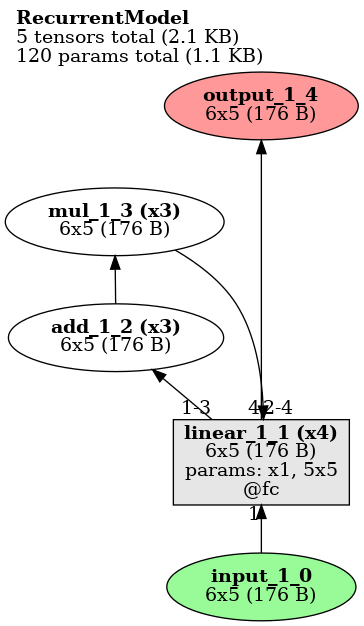

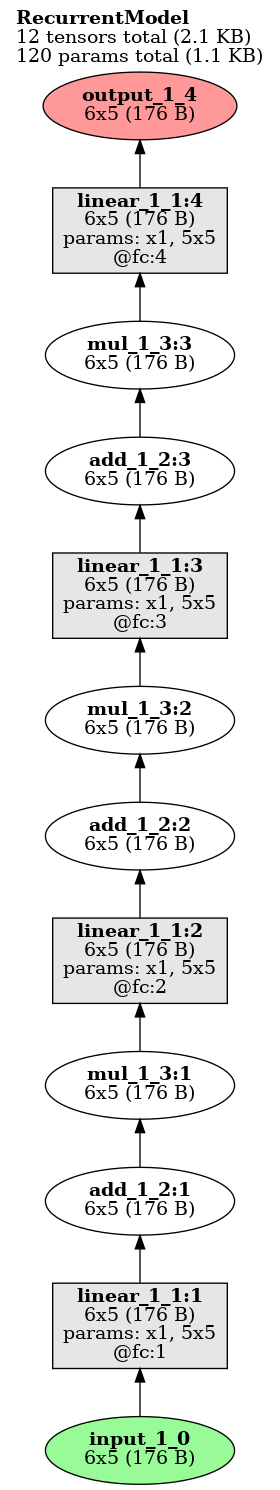

In [38]:
class RecurrentModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(in_features=5, out_features=5)

    def forward(self, x):
        x = self.fc(x)
        x = x + 1
        x = x * 2
        x = self.fc(x)
        x = x + 1
        x = x * 2
        x = self.fc(x)
        x = x + 1
        x = x * 2
        x = self.fc(x)
        return x


x = torch.rand(6, 5)
recurrent_mod = RecurrentModel()
tl.get_model_activations(recurrent_mod, x, vis_opt='unrolled')
model_history = tl.get_model_activations(recurrent_mod, x, vis_opt='rolled')

Different passes of a layer are indicated with a colon: for instance, 'linear_1_1:2' means the second pass of this layer. By default, torchlens adopts the convention that different operations are considered part of the same "layer" if the same parameters are applied for those operations (e.g., here the same set of fully connected weights is applied three times during the forward pass), **or** if an operation follows such a layer (e.g., the add and multiply operations after each fully conencted layer in this example model). These separate passes can be pulled out by indexing the model_history object:

In [40]:
model_history['linear_1_1:3']

Layer linear_1_1(pass 3/4), operation 8/12 (1.144E-03s elapsed):
	Output tensor: shape=(6, 5), dype=torch.float32, size=176 B
		tensor([[-5.3465,  5.4448,  1.3111,  0.1583, -0.6663],
        [-6.0490,  6.0465,  1.3780,  0.1262, -0.7715],
        [-6.0737,  6.3800,  1.7229,  0.2259, -0.6055],
        [-5.4851,  5.8586,  1.6673,  0.3082, -0.5596],
        [-5.3566,  5.5596,  1.4874,  0.2212, -0.5993]],
       grad_fn=<SliceBackward>)...
	Params: Computed from params with shape (5,), (5, 5); 30 params total (232 B)
	Parent Layers: mul_1_3:2
	Child Layers: add_1_2:3
	Function: linear (gradfunc=AddmmBackward) 
	Computed inside module: fc
	Output of modules: fc
	Output of bottom-level module: fc
	Lookup keys: -5, 7, fc:3, linear_1_1:3

Torchlens can also deal with models with:
- Internal branching
- Internal if-then logic that can change the computation graph based on input values
- Tensors that are generated inside the network (e.g., with torch.ones, torch.zeros, torch.rand, etc.) rather than coming from the input
- Randomness (here, you can set the random seed to make sure you get the same outputs from each pass)
- Models with a nested modular structure.

In [42]:
# Internal branching example

In [43]:
# If-then example

In [44]:
# Internally generated tensors example (tensors that don't arise from the input are shown with dashed outlines in the visual)

In [45]:
# Model with randomness

In [49]:
# Model with nested modules

The goal of torchlens is to work for any PyTorch model whatsoever. I have tested it for all models in torchvision's model zoo, but to validate the correctness of any saved activations for untested models, there is one more core function, validate_saved_activations, which algorithmically verifies that the model's activations are correctly saved by re-running the forward pass from each intermediate step of the model based on the saved activations and checking that the resulting output matches the ground truth. Additionally, as a further check, it substitutes in random nonsense activations in place of the saved activations during each step of this validation procedure, and verifies that the resulting output does *not* match the ground truth output. This function returns True if the saved activations pass this test, and False otherwise. **Please email johnmarkedwardtaylor@gmail.com if this ever returns False and torchlens will be updated to work with your model; this would be greatly appreciated, since it means you found an edge case that was missed.**


In [50]:
x = torch.rand(6, 3, 256, 256)
tl.validate_saved_activations(alexnet, x)


True